Disciplina: Aprendizagem de Máquina

Período: 2025.1

Professor: César Lincoln Cavalcante Mattos

Aluno: Davi Teixeira Silva

# Lista 4 - KNN e árvores de decisão

## Questão 1

Considere o conjunto de dados disponível em concrete.csv, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos referem-se à caracterização de diferentes tipos de concreto para construção civil. A saída é a resistência à compressão do concreto (em megapascals, MPa). Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/4353.

a) Considere um modelo de regressão não linear baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:

- MLP (multilayer perceptron): 1 camada oculta e treinamento em minibatch via gradiente descendente estocástico com termo de momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros.

b) Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também para os conjuntos de treino, validação e teste as métricas abaixo:

- RMSE (root mean squared error)
- MAE (mean absolute error)
- MRE (mean relative error)

Treinando com 5 neurônios...
Treinando com 6 neurônios...
Treinando com 7 neurônios...
Treinando com 8 neurônios...
Treinando com 9 neurônios...
Treinando com 10 neurônios...
Treinando com 11 neurônios...
Treinando com 12 neurônios...
Treinando com 13 neurônios...
Treinando com 14 neurônios...
Treinando com 15 neurônios...
Treinando com 16 neurônios...
Treinando com 17 neurônios...
Treinando com 18 neurônios...
Treinando com 19 neurônios...
Treinando com 20 neurônios...
Treinando com 21 neurônios...
Treinando com 22 neurônios...
Treinando com 23 neurônios...
Treinando com 24 neurônios...
Treinando com 25 neurônios...
Treinando com 26 neurônios...
Treinando com 27 neurônios...
Treinando com 28 neurônios...
Treinando com 29 neurônios...
Treinando com 30 neurônios...
Treinando com 31 neurônios...
Treinando com 32 neurônios...
Treinando com 33 neurônios...
Treinando com 34 neurônios...
Treinando com 35 neurônios...
Treinando com 36 neurônios...
Treinando com 37 neurônios...
Treinando com 3

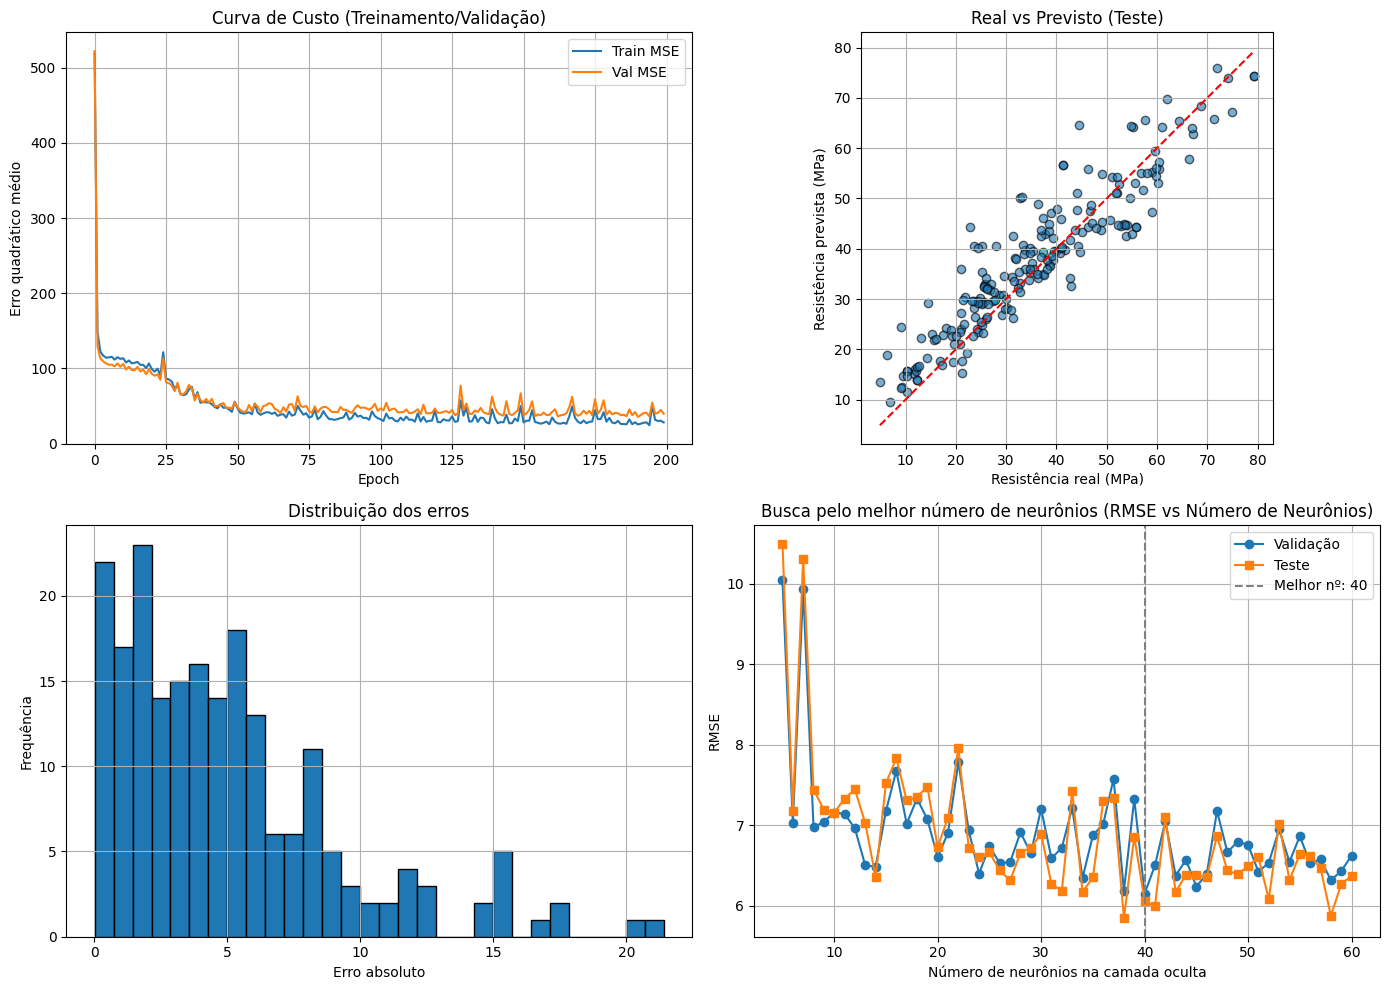

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. Data utilities
# -----------------------------------------------------------------------------

def load_and_prepare(path: str, seed: int = 42):
    raw_data = np.genfromtxt(path, delimiter=",")

    features = raw_data[:, :-1]
    targets = raw_data[:, -1:]

    # Min‑max normalisation of features
    min_vals, max_vals = features.min(axis=0), features.max(axis=0)
    features = (features - min_vals) / (max_vals - min_vals)

    # Shuffle data
    rng = np.random.default_rng(seed)
    indices = rng.permutation(features.shape[0])
    features, targets = features[indices], targets[indices]

    # Split into train (60%), val (20%), and test (20%)
    n = features.shape[0]
    n_train = int(0.6 * n)
    n_val   = int(0.2 * n)

    X_train, y_train = features[:n_train], targets[:n_train]
    X_val, y_val = features[n_train:n_train + n_val], targets[n_train:n_train + n_val]
    X_test, y_test = features[n_train + n_val:], targets[n_train + n_val:]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# -----------------------------------------------------------------------------
# 2. Activation functions & loss
# -----------------------------------------------------------------------------

def relu(x):
    return np.maximum(0.0, x)

def relu_grad(x):
    return (x > 0).astype(float)

def mse(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)

# -----------------------------------------------------------------------------
# 3. Evaluation metrics
# -----------------------------------------------------------------------------

def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

def mae(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true))

def mre(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true) / np.abs(y_true))

# -----------------------------------------------------------------------------
# 4. Multilayer Perceptron (1 hidden layer)
# -----------------------------------------------------------------------------

class MLP:
    def __init__(self, input_dim, hidden_dim, lr = 0.001, momentum = 0.9, seed = 42):

        rng = np.random.default_rng(seed)

        # Hidden layer - Weight initialization (He init for ReLU)
        self.W1 = rng.normal(0, np.sqrt(2 / input_dim), (input_dim, hidden_dim))
        self.b1 = np.zeros((1, hidden_dim))

        # Output layer
        self.W2 = rng.normal(0, np.sqrt(2 / hidden_dim), (hidden_dim, 1))
        self.b2 = np.zeros((1, 1))

        # Velocities for momentum
        self.vW1 = np.zeros_like(self.W1)
        self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2)
        self.vb2 = np.zeros_like(self.b2)

        self.lr = lr
        self.momentum = momentum

    # ---------- Forward pass ----------
    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1       # Linear transformation: input x weights
        self.A1 = relu(self.Z1)               # ReLU activation
        self.Z2 = self.A1 @ self.W2 + self.b2 # Output layer (linear)
        return self.Z2                        # linear output

    # ---------- Backward pass ----------
    def backward(self, X, y, y_pred):
        m = X.shape[0]
        error_output = (2 / m) * (y_pred - y)

        grad_W2 = self.A1.T @ error_output
        grad_b2 = np.sum(error_output, axis=0, keepdims=True)

        error_hidden = error_output @ self.W2.T
        grad_hidden = error_hidden * relu_grad(self.Z1)

        grad_W1 = X.T @ grad_hidden
        grad_b1 = np.sum(grad_hidden, axis=0, keepdims=True)

        return grad_W1, grad_b1, grad_W2, grad_b2

    # ---------- Parameter update ----------
    def step(self, grads):
        dW1, db1, dW2, db2 = grads
        # Update velocities
        self.vW1 = self.momentum * self.vW1 - self.lr * dW1
        self.vb1 = self.momentum * self.vb1 - self.lr * db1
        self.vW2 = self.momentum * self.vW2 - self.lr * dW2
        self.vb2 = self.momentum * self.vb2 - self.lr * db2
        # Update parameters
        self.W1 += self.vW1
        self.b1 += self.vb1
        self.W2 += self.vW2
        self.b2 += self.vb2

# -----------------------------------------------------------------------------
# 5. Training routine
# -----------------------------------------------------------------------------

def train(model, X_train, y_train, X_val, y_val, epochs = 200, batch_size = 32, seed = 42):

    rng = np.random.default_rng(seed)
    n_train = X_train.shape[0]

    metrics_history = {"train_mse": [], "val_mse": []}

    for epoch in range(epochs):

        # ----- Mini‑batch SGD -----
        indices = rng.permutation(n_train)

        for start in range(0, n_train, batch_size):
            end = start + batch_size
            batch_idx = indices[start:end]
            X_batch, y_batch = X_train[batch_idx], y_train[batch_idx]

            predictions = model.forward(X_batch)
            grads = model.backward(X_batch, y_batch, predictions)
            model.step(grads)

        # ----- Monitor loss on full train & val sets -----
        train_preds = model.forward(X_train)
        val_preds = model.forward(X_val)

        metrics_history["train_mse"].append(mse(train_preds, y_train))
        metrics_history["val_mse"].append(mse(val_preds, y_val))

    return metrics_history

# -----------------------------------------------------------------------------
# 6. Search for the best number of neurons
# -----------------------------------------------------------------------------

def search_best_neuron(X_train, y_train, X_val, y_val, X_test, y_test, neuronios_range, epochs=300):
    val_rmse_results = []
    test_rmse_results = []

    for n in neuronios_range:
        print(f"Treinando com {n} neurônios...")
        model = MLP(input_dim=X_train.shape[1], hidden_dim=n)
        train(model, X_train, y_train, X_val, y_val, epochs=epochs)

        preds_val = model.forward(X_val)
        preds_test = model.forward(X_test)

        val_rmse = rmse(preds_val, y_val)
        test_rmse = rmse(preds_test, y_test)

        val_rmse_results.append(val_rmse)
        test_rmse_results.append(test_rmse)

    best_idx = np.argmin(val_rmse_results)
    best_n = neuronios_range[best_idx]
    best_rmse = val_rmse_results[best_idx]
    print(f"\nMelhor número de neurônios: {best_n} com RMSE = {best_rmse:.4f}")

    return best_n, val_rmse_results, test_rmse_results

# -----------------------------------------------------------------------------
# 7. Putting everything together
# -----------------------------------------------------------------------------

def main():

    # Data
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_and_prepare("concrete.csv")

    # Step 1: Search for the best number of neurons
    neuronios_range = range(5, 61)
    best_n, val_rmse_results, test_rmse_results = search_best_neuron(X_train, y_train, X_val, y_val, X_test, y_test, neuronios_range)

    # Step 2: Final training with best_n
    model = MLP(input_dim = X_train.shape[1], hidden_dim = best_n)

    # Train model
    history = train(model, X_train, y_train, X_val, y_val)

    # Step 3: Final assessment
    # Final predictions for metrics
    pred_train = model.forward(X_train)
    pred_val = model.forward(X_val)
    pred_test = model.forward(X_test)

    def metrics(y_p, y_t):
        return rmse(y_p, y_t), mae(y_p, y_t), mre(y_p, y_t)

    # Calculate metrics
    rmse_train, mae_train, mre_train = metrics(pred_train, y_train)
    rmse_val, mae_val, mre_val = metrics(pred_val, y_val)
    rmse_test, mae_test, mre_test = metrics(pred_test, y_test)

    # Print formatted
    print("\nMetrics => (RMSE, MAE, MRE)")
    print(f"Train: RMSE = {rmse_train:.4f}, MAE = {mae_train:.4f}, MRE = {mre_train:.4f}")
    print(f"Valid: RMSE = {rmse_val:.4f}, MAE = {mae_val:.4f}, MRE = {mre_val:.4f}")
    print(f"Test : RMSE = {rmse_test:.4f}, MAE = {mae_test:.4f}, MRE = {mre_test:.4f}")
    #print()
    print("\n")

    # Plot cost curves ------------
    try:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.ravel()

        # Gráfico 1 - Curva de custo
        axes[0].plot(history["train_mse"], label="Train MSE")
        axes[0].plot(history["val_mse"],   label="Val MSE")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Erro quadrático médio")
        axes[0].set_title("Curva de Custo (Treinamento/Validação)")
        axes[0].legend()
        axes[0].grid(True)

        # Gráfico 2: Dispersão real vs previsto
        axes[1].scatter(y_test, pred_test, alpha=0.6, edgecolors='k')
        axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
        axes[1].set_xlabel("Resistência real (MPa)")
        axes[1].set_ylabel("Resistência prevista (MPa)")
        axes[1].set_title("Real vs Previsto (Teste)")
        axes[1].grid(True)
        axes[1].set_aspect('equal')  # mantém escala proporcional

        # Gráfico 3: Distribuição dos erros
        errors = np.abs(pred_test - y_test)
        axes[2].hist(errors, bins=30, edgecolor='k')
        axes[2].set_xlabel("Erro absoluto")
        axes[2].set_ylabel("Frequência")
        axes[2].set_title("Distribuição dos erros")
        axes[2].grid(True)

        # Gráfico 4 - RMSE vs n_neurônios
        axes[3].plot(neuronios_range, val_rmse_results, marker='o', label='Validação')
        axes[3].plot(neuronios_range, test_rmse_results, marker='s', label='Teste')
        axes[3].axvline(best_n, color="gray", linestyle="--", label=f"Melhor nº: {best_n}")
        axes[3].set_xlabel("Número de neurônios na camada oculta")
        axes[3].set_ylabel("RMSE")
        axes[3].set_title("Busca pelo melhor número de neurônios (RMSE vs Número de Neurônios)")
        axes[3].legend()
        axes[3].grid(True)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("Plot skipped (matplotlib not available):", e)

if __name__ == "__main__":
    main()


### Conclusão

Nesta primeira questão, tive a oportunidade de implementar uma rede neural simples do tipo perceptron multicamada (MLP) com apenas uma camada oculta, onde explorei diferentes quantidades de neurônios na camada oculta para encontrar a configuração que traz os melhores resultados, observando o impacto direto disso na taxa de erro (RMSE).

Por fim, com a ajuda de gráficos, pude visualizar o comportamento do modelo durante o treinamento, incluindo a curva de custo, a comparação entre valores reais e previstos, a distribuição dos erros e a relação entre o número de neurônios e o RMSE. Isso ajudou a interpretar melhor os resultados e refletir sobre o desempenho da rede em dados não vistos.

## Questão 2

Considere o conjunto de dados disponível em vowel.csv, organizado em 11 colunas, sendo as 10 primeiras colunas os atributos e a última coluna a saída. Os 10 atributos referem-se à caracterização de amostras da fala de britânicos. A saída é o fonema de vogal correspondente, dentre as 11 possibilidades. Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/307.

a) Considere um modelo de classificação não linear baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:

- MLP (multilayer perceptron): 1 camada oculta e treinamento em minibatch via gradiente descendente estocástico com termo de momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros.

b) Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também a acurácia obtida para os conjuntos de treino, validação e teste. Por último, mostre a matriz de confusão obtida no conjunto de teste.

Treinando com 5 neurônios...
Treinando com 6 neurônios...
Treinando com 7 neurônios...
Treinando com 8 neurônios...
Treinando com 9 neurônios...
Treinando com 10 neurônios...
Treinando com 11 neurônios...
Treinando com 12 neurônios...
Treinando com 13 neurônios...
Treinando com 14 neurônios...
Treinando com 15 neurônios...
Treinando com 16 neurônios...
Treinando com 17 neurônios...
Treinando com 18 neurônios...
Treinando com 19 neurônios...
Treinando com 20 neurônios...
Treinando com 21 neurônios...
Treinando com 22 neurônios...
Treinando com 23 neurônios...
Treinando com 24 neurônios...
Treinando com 25 neurônios...
Treinando com 26 neurônios...
Treinando com 27 neurônios...
Treinando com 28 neurônios...
Treinando com 29 neurônios...
Treinando com 30 neurônios...
Treinando com 31 neurônios...
Treinando com 32 neurônios...
Treinando com 33 neurônios...
Treinando com 34 neurônios...
Treinando com 35 neurônios...
Treinando com 36 neurônios...
Treinando com 37 neurônios...
Treinando com 3

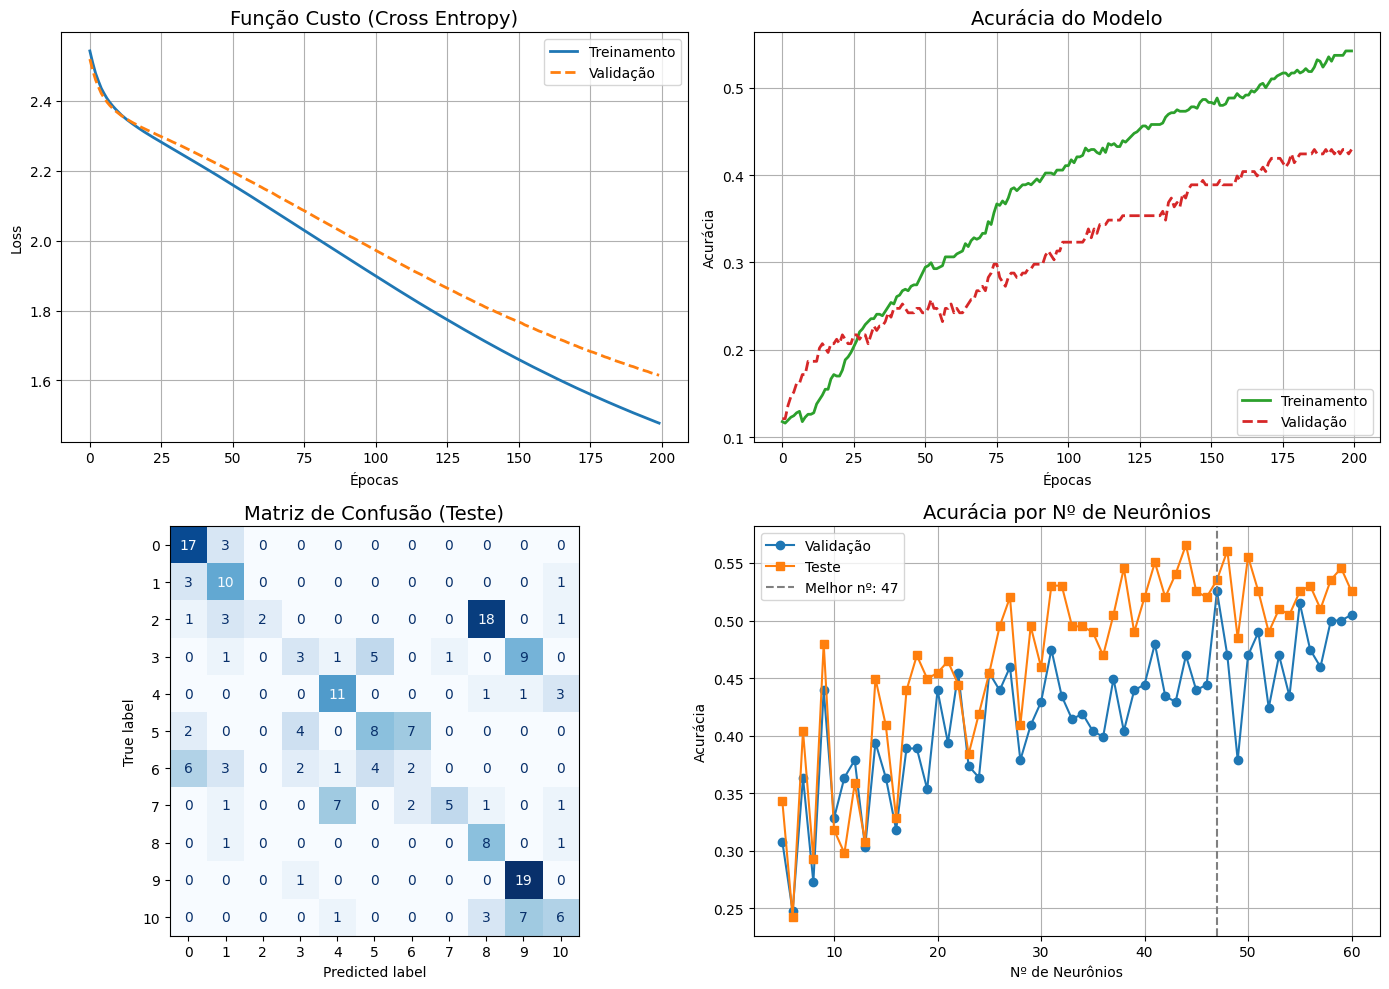

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------------------------------------------------------
# 1. Data utilities
# -----------------------------------------------------------------------------

def load_and_prepare(path: str, seed: int = 42):
    raw_data = np.genfromtxt(path, delimiter=",")

    features = raw_data[:, :-1]
    targets = raw_data[:, -1:].astype(int)

    # Min‑max normalisation of features
    min_vals, max_vals = features.min(axis=0), features.max(axis=0)
    features = (features - min_vals) / (max_vals - min_vals)

    # Shuffle data
    rng = np.random.default_rng(seed)
    indices = rng.permutation(features.shape[0])
    features, targets = features[indices], targets[indices]

    # Label encoding para rótulos contínuos
    unique_classes = np.unique(targets)
    label_map = {val: idx for idx, val in enumerate(unique_classes)}
    encoded_targets = np.vectorize(label_map.get)(targets).reshape(-1)

    # One-hot encoding
    num_classes = len(unique_classes)
    one_hot = np.eye(num_classes)[encoded_targets]

    # Split into train (60%), val (20%), and test (20%)
    n = features.shape[0]
    n_train = int(0.6 * n)
    n_val   = int(0.2 * n)

    X_train, y_train = features[:n_train], one_hot[:n_train]
    X_val, y_val = features[n_train:n_train + n_val], one_hot[n_train:n_train + n_val]
    X_test, y_test = features[n_train + n_val:], one_hot[n_train + n_val:]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# -----------------------------------------------------------------------------
# 2. Activation functions & loss
# -----------------------------------------------------------------------------

def relu(x):
    return np.maximum(0.0, x)

def relu_grad(x):
    return (x > 0).astype(float)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def cross_entropy(y_pred, y_true):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def accuracy(y_pred, y_true):
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return np.mean(y_pred_labels == y_true_labels)

# -----------------------------------------------------------------------------
# 3. Multilayer Perceptron (1 hidden layer)
# -----------------------------------------------------------------------------

class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim, lr = 0.001, momentum = 0.9, seed = 42):

        rng = np.random.default_rng(seed)

        # Hidden layer - Weight initialization (He init for ReLU)
        self.W1 = rng.normal(0, np.sqrt(2 / input_dim), (input_dim, hidden_dim))
        self.b1 = np.zeros((1, hidden_dim))

        # Output layer
        self.W2 = rng.normal(0, np.sqrt(2 / hidden_dim), (hidden_dim, output_dim))
        self.b2 = np.zeros((1, output_dim))

        # Velocities for momentum
        self.vW1 = np.zeros_like(self.W1)
        self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2)
        self.vb2 = np.zeros_like(self.b2)

        self.lr = lr
        self.momentum = momentum

    # ---------- Forward pass ----------
    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1       # Linear transformation: input x weights
        self.A1 = relu(self.Z1)               # ReLU activation
        self.Z2 = self.A1 @ self.W2 + self.b2 # Output layer (linear)
        self.out = softmax(self.Z2)           # Softmax activation
        return self.out                       # softmax output

    # ---------- Backward pass ----------
    def backward(self, X, y, y_pred):
        m = X.shape[0]
        error_output = (y_pred - y) / m

        grad_W2 = self.A1.T @ error_output
        grad_b2 = np.sum(error_output, axis=0, keepdims=True)

        error_hidden = error_output @ self.W2.T
        grad_hidden = error_hidden * relu_grad(self.Z1)

        grad_W1 = X.T @ grad_hidden
        grad_b1 = np.sum(grad_hidden, axis=0, keepdims=True)

        return grad_W1, grad_b1, grad_W2, grad_b2

    # ---------- Parameter update ----------
    def step(self, grads):
        dW1, db1, dW2, db2 = grads
        # Update velocities
        self.vW1 = self.momentum * self.vW1 - self.lr * dW1
        self.vb1 = self.momentum * self.vb1 - self.lr * db1
        self.vW2 = self.momentum * self.vW2 - self.lr * dW2
        self.vb2 = self.momentum * self.vb2 - self.lr * db2
        # Update parameters
        self.W1 += self.vW1
        self.b1 += self.vb1
        self.W2 += self.vW2
        self.b2 += self.vb2

# -----------------------------------------------------------------------------
# 4. Training routine
# -----------------------------------------------------------------------------

def train(model, X_train, y_train, X_val, y_val, epochs = 200, batch_size = 32, seed = 42):

    rng = np.random.default_rng(seed)
    n_train = X_train.shape[0]

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):

        # ----- Mini‑batch SGD -----
        indices = rng.permutation(n_train)

        for start in range(0, n_train, batch_size):
            end = start + batch_size
            batch_idx = indices[start:end]
            X_batch, y_batch = X_train[batch_idx], y_train[batch_idx]

            predictions = model.forward(X_batch)
            grads = model.backward(X_batch, y_batch, predictions)
            model.step(grads)

        # ----- Monitor loss on full train & val sets -----
        train_preds = model.forward(X_train)
        val_preds = model.forward(X_val)

        history["train_loss"].append(cross_entropy(train_preds, y_train))
        history["val_loss"].append(cross_entropy(val_preds, y_val))
        history["train_acc"].append(accuracy(train_preds, y_train))
        history["val_acc"].append(accuracy(val_preds, y_val))

    return history

# -----------------------------------------------------------------------------
# 5. Search for the best number of neurons
# -----------------------------------------------------------------------------

def search_best_neuron(X_train, y_train, X_val, y_val, X_test, y_test, neuronios_range, epochs=300):
    val_acc_results = []
    test_acc_results = []

    for n in neuronios_range:
        print(f"Treinando com {n} neurônios...")
        model = MLP(input_dim=X_train.shape[1], hidden_dim=n, output_dim=y_train.shape[1])
        train(model, X_train, y_train, X_val, y_val, epochs=epochs)

        preds_val = model.forward(X_val)
        preds_test = model.forward(X_test)

        val_acc = accuracy(preds_val, y_val)
        test_acc = accuracy(preds_test, y_test)

        val_acc_results.append(val_acc)
        test_acc_results.append(test_acc)

    best_idx = np.argmax(val_acc_results)
    best_n = neuronios_range[best_idx]
    best_acc = val_acc_results[best_idx]

    print(f"\nMelhor número de neurônios: {best_n} com Acurácia de Validação = {best_acc:.4f}")

    return best_n, val_acc_results, test_acc_results

# -----------------------------------------------------------------------------
# 6. Putting everything together
# -----------------------------------------------------------------------------

def main():

    # Data
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_and_prepare("vowel.csv")

    # Step 1: Search for the best number of neurons
    neuronios_range = range(5, 61)
    best_n, val_acc_results, test_acc_results = search_best_neuron(X_train, y_train, X_val, y_val, X_test, y_test, neuronios_range, epochs=200)

    # Step 1:
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    hidden_dim = 30

    # Step 2: Final training
    model = MLP(input_dim, hidden_dim, output_dim)

    # Train model
    history = train(model, X_train, y_train, X_val, y_val)

    # Step 3: Final assessment
    # Final predictions for metrics
    pred_train = model.forward(X_train)
    pred_val = model.forward(X_val)
    pred_test = model.forward(X_test)

    # Print formatted
    print("\nAcurácias:")
    print(f"Treino: {accuracy(pred_train, y_train) * 100:.2f}%")
    print(f"Validação: {accuracy(pred_val, y_val) * 100:.2f}%")
    print(f"Teste: {accuracy(pred_test, y_test) * 100:.2f}%\n")

    # Plot cost curves ------------
    try:

      fig, axes = plt.subplots(2, 2, figsize=(14, 10))
      axes = axes.ravel()

      # Gráfico 1: Função Custo (Loss)
      axes[0].plot(history["train_loss"], label="Treinamento", color="#1f77b4", linewidth=2)
      axes[0].plot(history["val_loss"], label="Validação", color="#ff7f0e", linewidth=2, linestyle="--")
      axes[0].set_title("Função Custo (Cross Entropy)", fontsize=14)
      axes[0].set_xlabel("Épocas")
      axes[0].set_ylabel("Loss")
      axes[0].legend(loc="upper right")
      axes[0].grid(True)

      # Gráfico 2: Acurácia
      axes[1].plot(history["train_acc"], label="Treinamento", color="#2ca02c", linewidth=2)
      axes[1].plot(history["val_acc"], label="Validação", color="#d62728", linewidth=2, linestyle="--")
      axes[1].set_title("Acurácia do Modelo", fontsize=14)
      axes[1].set_xlabel("Épocas")
      axes[1].set_ylabel("Acurácia")
      axes[1].legend(loc="lower right")
      axes[1].grid(True)

      # Gráfico 3: Matriz de Confusão
      y_true = np.argmax(y_test, axis=1)
      y_pred = np.argmax(pred_test, axis=1)
      cm = confusion_matrix(y_true, y_pred)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm)
      disp.plot(ax=axes[2], cmap="Blues", colorbar=False)
      axes[2].set_title("Matriz de Confusão (Teste)", fontsize=14)

      # Gráfico 4: Comparação de acurácia por nº de neurônios
      axes[3].plot(neuronios_range, val_acc_results, label="Validação", marker='o', color="#1f77b4")
      axes[3].plot(neuronios_range, test_acc_results, label="Teste", marker='s', color="#ff7f0e")
      axes[3].axvline(best_n, color="gray", linestyle="--", label=f"Melhor nº: {best_n}")
      axes[3].set_title("Acurácia por Nº de Neurônios", fontsize=14)
      axes[3].set_xlabel("Nº de Neurônios")
      axes[3].set_ylabel("Acurácia")
      axes[3].legend()
      axes[3].grid(True)

      plt.tight_layout()
      plt.show()

    except Exception as e:
      print("Plot skipped (matplotlib not available):", e)

if __name__ == "__main__":
    main()


### Conclusão

Nesta segunda questão, tive a oportunidade de implementar uma rede neural simples do tipo perceptron multicamada (MLP) com apenas uma camada oculta, onde apliquei o monitoramento da função custo (cross-entropy) e da acurácia ao longo das épocas. Além disso, explorei diferentes quantidades de neurônios na camada oculta para encontrar a configuração que traz os melhores resultadosem diferentes configurações e encontrar um equilíbrio entre capacidade de generalização e complexidade do modelo.

Por fim, os resultados obtidos mostraram um aumento gradual na acurácia tanto em treino quanto em validação, com desempenho razoável também no conjunto de teste. A matriz de confusão permitiu visualizar de forma clara os acertos e erros por classe, enquanto o gráfico de comparação das acurácias reforçou a importância da escolha adequada do número de neurônios na camada intermediária.